In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
from sklearn.model_selection import train_test_split

# Testing CUDA

In [2]:
def make_nn():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(1, input_shape=(1,)))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

def dataset():
    x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
    y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
    return tf.data.Dataset.from_tensor_slices((x, y)).batch(1)



def main():
    model = make_nn()
    model.fit(dataset(), epochs=1, steps_per_epoch=9)

if __name__ == '__main__':
    print(f"GPUs available: {tf.config.list_physical_devices('GPU')}")
    print(f"Built with cuda: {tf.test.is_built_with_cuda()}")

    main()

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with cuda: True
9/9 [==============================] - 11s 15ms/step - loss: 22.1515


In [5]:
df=pd.read_csv("../dataset/logs_with_roles.csv")
df.head(5)

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,user_roles
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,External Contractor
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,Employee
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,Employee
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,Employee
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,Employee


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  user_roles           9537 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 819.7+ KB


# Drop Irrelevant Column

In [7]:
df = df.drop(columns=["session_id"])

# Separate numerical and categorical features

In [8]:
num_features = ["network_packet_size", "login_attempts", "session_duration", "ip_reputation_score", "failed_logins", "unusual_time_access"]
cat_features = ["protocol_type", "encryption_used", "browser_type", "user_roles"]

# Normalize Numerical Feaatures

In [9]:
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

In [10]:
# Save Scaler
joblib.dump(scaler, "../model/v4/scaler.pkl")

['../model/v4/scaler.pkl']

# One-hot encode categorical features

In [11]:
encoder = OneHotEncoder(sparse=False, drop="first")
encoded_cats = encoder.fit_transform(df[cat_features])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(cat_features))

In [12]:
# Save the encoder
joblib.dump(encoder, "../model/v4/encoder.pkl")

['../model/v4/encoder.pkl']

# Merge encoded data

In [13]:
df = df.drop(columns=cat_features).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

In [14]:
df

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,encryption_used_nan,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown,user_roles_Employee,user_roles_External Contractor,user_roles_IT,user_roles_Security Analyst
0,0.438165,0.250000,0.068497,0.655587,0.2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.334152,0.166667,0.216623,0.324443,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.462735,0.166667,0.010368,0.799160,0.4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.606061,0.250000,0.083555,0.131015,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.318591,0.333333,0.073998,0.056820,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9532,0.106470,0.166667,0.031370,0.558949,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9533,0.258804,0.166667,0.025362,0.440429,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9534,0.491400,0.333333,0.004822,0.386963,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9535,0.280098,0.250000,0.011984,0.580298,0.2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Convert to numpy array

In [15]:
X = df.values

# Define autoencoder architecture

In [16]:
input_dim = X.shape[1]
encoding_dim = 8  # Bottleneck layer size

In [17]:
input_layer = keras.Input(shape=(input_dim,))

# Encoder with batch normalization

In [18]:
encoded = layers.Dense(32, activation="relu")(input_layer)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(16, activation="relu")(encoded)
encoded = layers.Dense(encoding_dim, activation="relu")(encoded)

# Decoder

In [19]:
decoded = layers.Dense(16, activation="relu")(encoded)
decoded = layers.BatchNormalization()(decoded)
decoded = layers.Dense(32, activation="relu")(decoded)
decoded = layers.Dense(input_dim, activation="sigmoid")(decoded) # Using sigmoid because my values are between 0 and 1 (After normalization)

# Build and compile model

In [20]:
autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Early stopping to monitor validation loss

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train autoencoder


In [22]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [23]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
239/239 [==============================] - 5s 12ms/step - loss: 0.1109 - val_loss: 0.0782
Epoch 2/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0588 - val_loss: 0.0473
Epoch 3/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0476 - val_loss: 0.0389
Epoch 4/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0405 - val_loss: 0.0313
Epoch 5/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0339 - val_loss: 0.0251
Epoch 6/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0289 - val_loss: 0.0208
Epoch 7/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0255 - val_loss: 0.0181
Epoch 8/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0227 - val_loss: 0.0154
Epoch 9/100
239/239 [==============================] - 3s 11ms/step - loss: 0.0199 - val_loss: 0.0133
Epoch 10/100
239/239 [==============================] - 3s 11ms/step - loss: 0.018

# Plot training loss

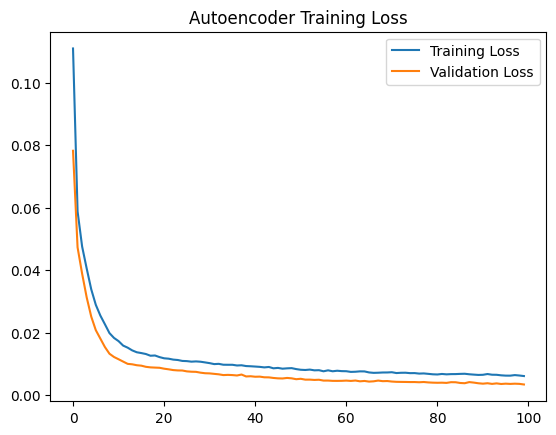

In [24]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()

# Compute reconstruction error

In [25]:
reconstructed = autoencoder.predict(X)
reconstruction_errors = np.mean(np.abs(X - reconstructed), axis=1)

299/299 [==============================] - 1s 4ms/step


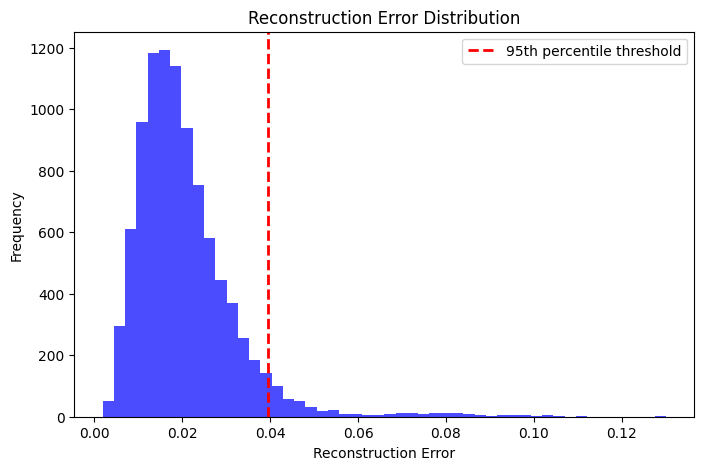

In [26]:
plt.figure(figsize=(8,5))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.axvline(np.percentile(reconstruction_errors, 95), color='red', linestyle='dashed', linewidth=2, label='95th percentile threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()

# Set anomaly detection threshold (e.g., 95th percentile)

In [27]:
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold

In [28]:
# Export threshold
joblib.dump(threshold, "../model/v4/threshold.pkl")

['../model/v4/threshold.pkl']

In [29]:
print(f"Detected Anomalies: {np.sum(anomalies)}")

Detected Anomalies: 477


In [31]:
df_anomalies = df.iloc[np.where(anomalies)]
df_anomalies[num_features] = scaler.inverse_transform(df_anomalies[num_features])

decoded_cats = encoder.inverse_transform(df_anomalies[encoder.get_feature_names_out(cat_features)])

# Convert to DataFrame
decoded_cats_df = pd.DataFrame(decoded_cats, columns=cat_features)

# Merge back with the anomaly dataframe
df_anomalies = df_anomalies.drop(columns=encoder.get_feature_names_out(cat_features)).reset_index(drop=True)
df_anomalies = pd.concat([df_anomalies, decoded_cats_df], axis=1)

df_anomalies.head(5)

C:\Users\3ehen\AppData\Local\Temp\ipykernel_8836\1621347210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalies[num_features] = scaler.inverse_transform(df_anomalies[num_features])


,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type,encryption_used,browser_type,user_roles
0,406.0,9.0,191.052837,0.339711,1.0,0.0,UDP,DES,Edge,Employee
1,548.0,2.0,186.147638,0.406899,2.0,1.0,TCP,NaN,Safari,Employee
2,108.0,7.0,3325.308689,0.079509,2.0,0.0,TCP,AES,Firefox,Security Analyst
3,493.0,1.0,4282.643311,0.427157,1.0,0.0,UDP,DES,Unknown,IT
4,266.0,5.0,265.801795,0.310700,2.0,1.0,TCP,NaN,Safari,External Contractor


# Inferencing Example

In [32]:
anomaly_data = {
    "network_packet_size": 406.0,
    "login_attempts": 9.0,
    "session_duration": 191.052837,
    "ip_reputation_score": 0.339711,
    "failed_logins": 1.0,
    "unusual_time_access": 0.0,
    "protocol_type": "UDP",
    "encryption_used": "DES",
    "browser_type": "Edge",
    "user_roles": "Employee"
}

# Convert to DataFrame
new_df = pd.DataFrame([anomaly_data])

# Normalize numerical features
new_df[num_features] = scaler.transform(new_df[num_features])  # Use the same scaler!

# One-hot encode categorical features
new_encoded = encoder.transform(new_df[cat_features])
new_encoded_df = pd.DataFrame(new_encoded, columns=encoder.get_feature_names_out(cat_features))

# Merge preprocessed features
new_df = new_df.drop(columns=cat_features).reset_index(drop=True)
new_df = pd.concat([new_df, new_encoded_df], axis=1)

# Convert to NumPy array for TensorFlow
new_input = new_df.to_numpy()

In [33]:
# Pass the input through the autoencoder
reconstructed = autoencoder.predict(new_input)

# Compute Reconstruction Error (MAE)
error = np.mean(np.abs(new_input - reconstructed))

print(f"Reconstruction Error: {error:.6f}")

if error > threshold:
    print("🚨 Anomalous Data Point Detected!")
else:
    print("✅ Normal Data Point")

1/1 [==============================] - 0s 32ms/step
Reconstruction Error: 0.039749
🚨 Anomalous Data Point Detected!


# Predicting a Random Row from Dataset

In [35]:
random_row = df.sample(1, random_state=42)
new_input = random_row.to_numpy()

reconstructed = autoencoder.predict(new_input)

error = np.mean(np.abs(new_input - reconstructed))

print(f"Reconstruction Error: {error:.6f}")

if error > threshold:
    print("🚨 Anomalous Data Point Detected!")
else:
    print("✅ Normal Data Point")

1/1 [==============================] - 0s 27ms/step
Reconstruction Error: 0.023695
✅ Normal Data Point


# Save Model

In [30]:
autoencoder.save("../model/v4/autoencoder.h5")